# Cifar-10 이미지 분류 v2
- 데이터 부풀리기 적용

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train,y_train),(X_test,y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [4]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
#xdata -scaling
X_train=X_train/255.
X_test=X_test/255.


In [7]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test=to_categorical(y_test)

- 모델 정의/학습/평가

In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten, MaxPooling2D, Dropout
#flatten - 3차원인 conv2D를 1차원인 dense, fully connected layer로 
#넣어야 하기 때문에 차원 축소를 할 때 필요.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [9]:
model =Sequential([
                   Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3),padding='same',activation='relu'),
                    #= MaxPooling2D(pool_size=(2,2))
                   # input_shape=(32,32,3) = X_train.shape[1:]
                    Conv2D(32, kernel_size=(3,3),activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3,3), padding='same',activation='relu'),
                    Conv2D(64, kernel_size=(3,3),activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.25),
                    Flatten(), #24,24,64에서 1차원 512개의 노드로.
                    Dense(512,activation='relu'),
                    Dropout(0.5),
                    Dense(10,activation='softmax')
])
model.summary()

#18496=32 x 3 x 3 x 64 + 64

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [10]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001,decay=1e-6),
              loss='categorical_crossentropy',metrics=['accuracy'])


In [11]:
model_path = 'best-cifar10-v2.h5'
mc=ModelCheckpoint(model_path,save_best_only=True,verbose=1)
es=EarlyStopping(patience=10)

- 데이터 부풀리기

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_valid,Y_train,Y_valid = train_test_split(
    X_train,Y_train,stratify=Y_train, test_size=0.2,random_state=seed
)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [17]:
datagen.fit(X_train)

- 데이터 부풀리기 한 결과로 학습

In [18]:
hist=model.fit(
    datagen.flow(X_train,Y_train,batch_size=32),
    validation_data=(X_valid,Y_valid),
    epochs=100,
    callbacks=[mc,es]
)

Epoch 1/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.8980 - accuracy: 0.2967
Epoch 1: val_loss improved from inf to 1.65834, saving model to best-cifar10-v2.h5
1250/1250 [==============================] - 30s 16ms/step - loss: 1.8981 - accuracy: 0.2966 - val_loss: 1.6583 - val_accuracy: 0.4022
Epoch 2/100
1247/1250 [============================>.] - ETA: 0s - loss: 1.6367 - accuracy: 0.3990
Epoch 2: val_loss improved from 1.65834 to 1.50025, saving model to best-cifar10-v2.h5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.6369 - accuracy: 0.3990 - val_loss: 1.5002 - val_accuracy: 0.4560
Epoch 3/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.5411 - accuracy: 0.4397
Epoch 3: val_loss improved from 1.50025 to 1.37033, saving model to best-cifar10-v2.h5
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5409 - accuracy: 0.4397 - val_loss: 1.3703 - val_accuracy: 0.5034
Epoch 4/100
1250/1250 [==================

In [19]:
best_model = load_model(model_path)
best_model.evaluate(X_test,Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8007 - accuracy: 0.7191


[0.8006633520126343, 0.7190999984741211]

Text(0.5, 0, 'Epoch')

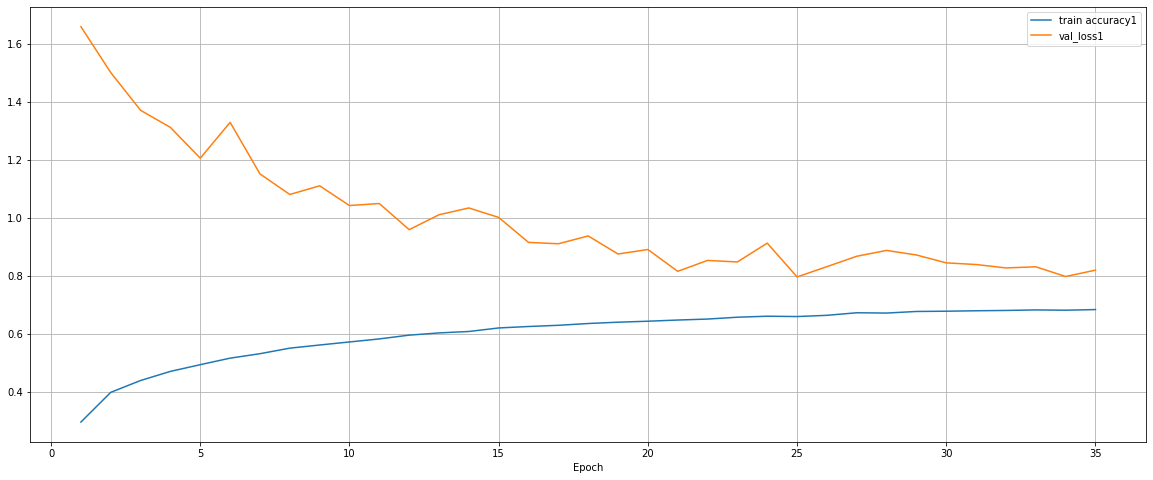

In [20]:
y_acc=hist.history['accuracy']
y_vloss=hist.history['val_loss']
xs=np.arange(1, len(y_acc)+1)
plt.figure(figsize=(20,8))
plt.plot(xs,y_acc,label='train accuracy1')
plt.plot(xs,y_vloss,label='val_loss1')
plt.legend(),
plt.grid(),
plt.xlabel('Epoch')